## Final problem

* Тематическое моделирование обращений с сайта Роспотребнадзора.

In [1]:
import pandas as pd
from multiprocessing import cpu_count, Pool
import time
import re
import pymorphy2

Файл "all_texts.csv" содержит 1000 страниц обращений с сайта Роспотребнадзора, полученных с помощью ассинхронных функций из файла "parser2.py".

In [2]:
df = pd.read_csv('all_texts.csv').drop(['Unnamed: 0'], axis=1)

### Нормализация

In [3]:
def norm(s):
    morph = pymorphy2.MorphAnalyzer()
    s = re.sub(r'[\d\$\%\#\@\№\^&\*.,A-z;!?():/<>"\'«»\r\n\t-]', ' ', s)
    s = ' '.join([morph.parse(i)[0].normal_form for i in s.split(' ')])
    s = re.sub(r'это', ' ', s)
    s = re.sub(r'добрый', ' ', s)
    s = re.sub(r'день', ' ', s)
    s = re.sub(r'который', ' ', s)
    s = re.sub(r'год', ' ', s)
    s = re.sub(r'\s..\s', ' ', s)
    s = re.sub(r'Здравствуйте', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s

In [4]:
with Pool(cpu_count()-1) as pool:
    start = time.time()
    df['text_norm'] = pool.map(norm, df['text'])
    print('execution time: ', time.time()-start)

execution time:  122.05573868751526


In [5]:
df.head()

,text,category,text_norm
0,Здравствуйте! 7 февраля 2020 года были куплены...,Транспортные услуги,февраль быть купить билет март евпатория моск...
1,Добрый день!\r\nМоим отцом оплачен подмосковны...,Туристские услуги,мой отец оплатить подмосковный отель солнечны...
2,"Здравствуйте, можете ли Вы проконсультировать,...",Жилищно-коммунальные услуги,мочь вы проконсультировать что делать в следу...
3,"Здравствуйте, можете ли Вы проконсультировать,...",Жилищно-коммунальные услуги,мочь вы проконсультировать что делать в следу...
4,"Здравствуйте, можете ли Вы проконсультировать,...",Жилищно-коммунальные услуги,мочь вы проконсультировать что делать в следу...


In [6]:
text_norm = df['text_norm'].values

### Векторизация

In [288]:
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 7))
    plt.subplot(title='10 самых популярных слов')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Слова')
    plt.ylabel('Количество')
    plt.show()

In [289]:
stopwords = set(nltk_stopwords.words('russian'))
count_vec = CountVectorizer(stop_words=stopwords)
vec_data = count_vec.fit_transform(text_norm)

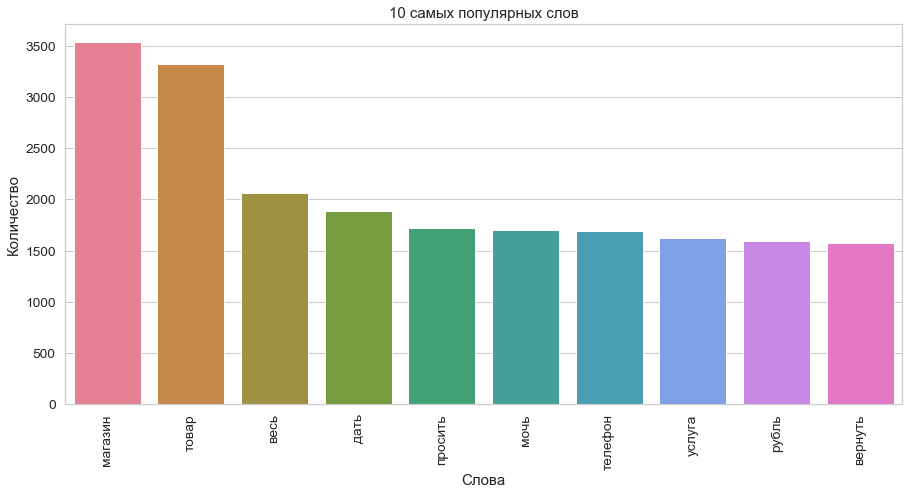

In [290]:
plot_10_most_common_words(vec_data, count_vec)

### Кластеризация

#### ПРЕДПОСЫЛКИ:

На сайте Роспотребнадзора каждое обращение было отнесено к конкретной категории. Всего таких категорий 11.

Исходя из этого, появляется предположение, что в результате кластеризации тексты обращений разделятся на кластеры, соответствующие конкретной категории.

Таким образом, для кластеризации текстов обращений решено было использовать 11 кластеров.  


In [300]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda_model = LDA(n_components=11, learning_method = 'batch', 
                evaluate_every = -1, random_state = 5, max_iter=20, learning_decay = 0.9)

In [301]:
news_topics = lda_model.fit_transform(vec_data)

In [343]:
n_top_words = 8
topic_summaries = []
topic_word = lda_model.components_
vocab = count_vec.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(" ".join(topic_words))
    print("Topic {}: {}".format(i+1, " | ".join(topic_words)))

Topic 1: ремонт | телефон | центр | сервисный | работа | гарантийный | мастер | дать
Topic 2: ребёнок | санитарный | продукция | продукт | просить | школа | питание | кафе
Topic 3: билет | авиакомпания | рейс | ответ | возврат | победа | обращение | сайт
Topic 4: товар | право | потребитель | договор | закон | ооо | защита | срок
Topic 5: медицинский | врач | весь | ребёнок | работа | осмотр | страховой | тур
Topic 6: услуга | рубль | договор | карта | компания | средство | счёт | сумма
Topic 7: аптека | препарат | доставка | маска | андрей | иметь | сдэк | лекарство
Topic 8: весь | время | дать | просить | сказать | номер | человек | мочь
Topic 9: магазин | товар | вернуть | возврат | продавец | заказ | сказать | мочь
Topic 10: посылка | почта | ооо | адрес | рубль | просить | счётчик | платёж
Topic 11: дом | квартира | наш | весь | просить | адрес | ребёнок | находиться


In [340]:
df.category.unique()

array(['Транспортные услуги', 'Туристские услуги',
       'Жилищно-коммунальные услуги', 'Прочие виды деятельности',
       'Розничная торговля', 'Медицинские услуги', 'Общественное питание',
       'Финансовые услуги', 'Услуги связи', 'Бытовое обслуживание',
       'Образовательные услуги'], dtype=object)

#### ВЫВОДЫ:

В результате кластеризации были получены следующие кластеры:

* *Topic 1* - Самые популярные слова данного кластера характеризуют его как **Бытовое обслуживание**;

* *Topic 2* - Второй кластер характеризуют такие слова, как: питание, кафе. Можно предположить, что данный кластер отражает **Общественное питание**. Также данный кластер содержит слова: ребенок, школа, что отражает **Образовательные услуги**;

* *Topic 3* - **Транспортные и Туристские услуги**;

* *Topic 4* - Такой категории обращения нет в исходном списке. Данных кластер отражает защиту прав потребителей в целом. Отнесем его к **Прочим видам деятельности**;

* *Topic 5* - **Медицинские услуги**;

* *Topic 6* - **Финансовые услуги**;

* *Topic 7* - Седьмой кластер содержит слова, связанные с доставкой из аптеки. Данный кластер появился из-за недавно возникшей пандемии. Назовем его **Доставка медикаментов**;

* *Topic 8* - Данный кластер не определен;

* *Topic 9* - **Розничная торговля**;

* *Topic 10* - **Услуги связи**;

* *Topic 11* - **Жилищно-коммунальные услуги**.

Таким образом, можно сделать вывод, что в целом кластеризация обращений прошла успешно. Были получены кластеры соответствующие выдвинутым предположениям. 

### t-SNE

In [304]:
tfidf = TfidfVectorizer(stop_words=stopwords)
tfidf_data = tfidf.fit_transform(text_norm)

In [305]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components = 2, random_state = 27)
tsne_tfidf = tsne_model.fit_transform(tfidf_data)

In [315]:
topic_word = lda_model.components_

In [331]:
news_topics = np.matrix(news_topics)

lda_keys = []
for i, tweet in enumerate(df["text_norm"]):
    lda_keys += [news_topics[i].argmax()+1]

In [332]:
tsne_df = pd.DataFrame(tsne_tfidf)
tsne_df.columns = ["x", "y"]
tsne_df["text_norm"] = df["text_norm"].values
tsne_df["category"] = df["category"].values
tsne_df["topics"] = lda_keys
tsne_df["topics"] = tsne_df["topics"].map(int)

In [360]:
tsne_df.head()

,x,y,text_norm,category,topics
0,-18.233686,-65.852303,февраль быть купить билет март евпатория моск...,Транспортные услуги,3
1,-45.033520,-52.075329,мой отец оплатить подмосковный отель солнечны...,Туристские услуги,5
2,-6.818738,-18.944189,мочь вы проконсультировать что делать в следу...,Жилищно-коммунальные услуги,9
3,-6.818738,-18.944189,мочь вы проконсультировать что делать в следу...,Жилищно-коммунальные услуги,9
4,-6.817657,-18.944506,мочь вы проконсультировать что делать в следу...,Жилищно-коммунальные услуги,9


In [334]:
tsne_df.topics.value_counts()

9     1823
6      563
11     560
4      393
1      378
2      366
8      334
10     255
3      142
5      129
7       57
Name: topics, dtype: int64

In [335]:
x = tsne_df['x'].values
y = tsne_df['y'].values

### Визуализация кластеризации

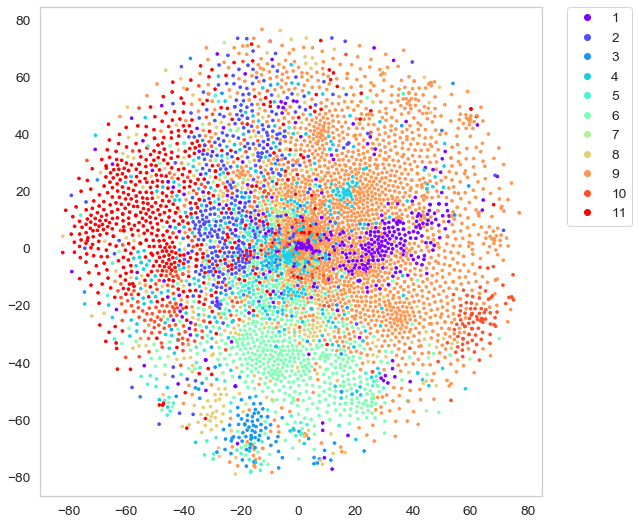

In [361]:
plt.figure(figsize=[9,9])
lbl = tsne_df['topics'].unique()
labels = [i for i in sorted(lbl)]

col = tsne_df.topics.astype('category').cat.codes

cmap = plt.cm.get_cmap('rainbow', tsne_df.topics.nunique())
scatter = plt.scatter(x = x, y = y, s = 7, c=col, cmap=cmap)
plt.legend(handles = scatter.legend_elements()[0], labels = labels,
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(False)
plt.show()

### Визуализация исходных категорий

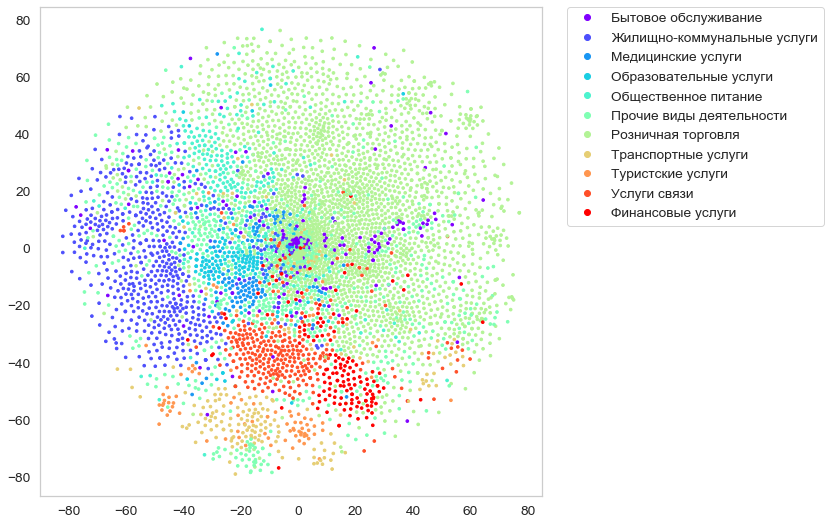

In [364]:
plt.figure(figsize=[9,9])
lbl = tsne_df['category'].unique()
labels = [i for i in sorted(lbl)]

col = tsne_df.category.astype('category').cat.codes

cmap = plt.cm.get_cmap('rainbow', tsne_df.category.nunique())
scatter = plt.scatter(x = x, y = y, s = 7, c=col, cmap=cmap)
plt.legend(handles = scatter.legend_elements()[0], labels = labels,
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(False)
plt.show()

## Вывод

Таким образом, можно сделать вывод о том, что полученные кластеры с обращениями в целом соответствуют исходным категориям на сайте Роспотребнадзора.